# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries
In order to excecute the code we are gonna install and import the necessary libraries.
First of all we are gonna install the last version of bitsandbytes in order to been able to use the quantization.

In [1]:
%%capture
%pip install -U bitsandbytes

Then we need to reload the notebook kernel

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  # Restart the kernel

Finally we are able to import the required libraries

In [1]:
import os
import requests
import re
import random
import gc
from pathlib import Path
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [2]:
%%capture
!pip install huggingface_hub

In [3]:
import huggingface_hub

huggingface_hub.notebook_login()

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [4]:
class SexismDetector:
    def __init__(self):
        self.seed = 42
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.DATA_FOLDER = Path("data")

        # Create data folder if it doesn't exist
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        self.clear_cache()

    def clear_cache(self) -> None:
        """
        Clears the GPU cache and performs garbage collection.
        This method uses PyTorch's `torch.cuda.empty_cache()` to release all unoccupied cached memory
        currently held by the caching allocator so that those can be used in other GPU applications.
        It also calls Python's garbage collector to free up memory that is no longer in use.
        Returns:
            None
        """
        torch.cuda.empty_cache()

        with torch.no_grad():
            torch.cuda.empty_cache()

        gc.collect()

    def download_corpus(self, url: str) -> pd.DataFrame:
        """
        Downloads a corpus from the given URL and saves it as a CSV file in the data folder.
        Args:
            url (str): The URL of the corpus to download.
        Returns:
            pd.DataFrame: A DataFrame containing the contents of the downloaded CSV file.
        Raises:
            requests.exceptions.RequestException: If there is an issue with the HTTP request.
        """
        filename = url.split("/")[-1]
        if not (self.DATA_FOLDER / filename).exists():
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

        return pd.read_csv(self.DATA_FOLDER / filename, encoding='utf-8')

    def load_model(self, model_card: str, with_4_bit: bool = True) -> tuple:
        """
        Loads a pre-trained model and its tokenizer with optional 4-bit quantization.

        Args:
            model_card (str): The identifier of the pre-trained model to load.
            with_4_bit (bool, optional): If True, loads the model with 4-bit quantization.
                                         If False, loads the model with 8-bit quantization.
                                         Defaults to True.

        Returns:
            tuple: A tuple containing the loaded model and tokenizer.
        """
        # Clear cache
        self.clear_cache()

        # Setup the quantization config
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        if with_4_bit:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="fp4",
                bnb_4bit_compute_dtype=torch.bfloat16
            )
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        # Load the model
        model = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
        # Set the model to evaluation (inference) mode
        model.eval()

        return model, tokenizer

    def prepare_prompts(self, texts: pd.Series, prompt_template: list, tokenizer: AutoTokenizer) -> list:
        """
        Prepares prompts by applying a chat template to a series of input texts.

        Args:
            texts (pd.Series): A pandas Series containing the input texts.
            prompt_template (list): A list representing the prompt template with placeholders.
            tokenizer (AutoTokenizer): An instance of the AutoTokenizer used to tokenize the prompts.

        Returns:
            list: A list of tokenized prompts ready for generation.
        """
        # Store the prompts
        prompts = []
        # Iterate over the input texts
        for text in texts:

            # Create a deepcopy of the prompt template
            prompt_with_text = deepcopy(prompt_template)

            # Replace the placeholder with the input text
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

            # Apply the chat template to the input text
            full_prompt = tokenizer.apply_chat_template(
                prompt_with_text,
                tokenize=True,
                add_generation_prompt=True,
                return_dict=True,
                return_tensors="pt")
            # Move the full prompt to the device
            full_prompt = full_prompt.to(self.device)
            # Append the full prompt to the list of prompts
            prompts.append(full_prompt)

        return prompts

    def generate_responses(self, model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompt_examples: list, max_new_tokens: int = 1000) -> list:
        """
        Generates responses for a list of prompt examples using a specified language model and tokenizer.

        Args:
            model (AutoModelForCausalLM): The language model to use for generating responses.
            tokenizer (AutoTokenizer): The tokenizer associated with the language model.
            prompt_examples (list): A list of prompt examples to generate responses for.
            max_new_tokens (int, optional): The maximum number of new tokens to generate for each prompt. Defaults to 1000.

        Returns:
            list: A list of generated responses corresponding to each prompt example.
        """
        answers = []
        for prompt in tqdm(prompt_examples):
            response = model.generate(**prompt, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)
            answers.append(response)
        return answers

    def process_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> int:
        """
        Processes the response tensor and determines if it contains a positive indication.

        Args:
            response (torch.Tensor): The tensor containing the response from the model.
            tokenizer (AutoTokenizer): The tokenizer used to decode the response tensor.

        Returns:
            int: Returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.
        """
        response_text = tokenizer.decode(response[0])
        if 'YES' in response_text.split('ANSWER')[-1]:
            return 1
        else:
            return 0

    def get_generated_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> str:
        """
        Decodes a tensor response into a cleaned string.

        Args:
            response (torch.Tensor): The tensor containing the response to decode.
            tokenizer (AutoTokenizer): The tokenizer used to decode the response.

        Returns:
            str: The cleaned and decoded response string.
        """
        response_text = tokenizer.decode(response[0])
        response_text = response_text.split('[/INST]')[-1]
        cleaned_string = re.sub(r'</s>', '', response_text).strip()
        return cleaned_string

    def compute_metrics(self, responses: list, y_true: list, tokenizer: AutoTokenizer) -> dict:
        """
        Compute the accuracy and fail ratio of the model's predictions.

        Args:
            responses (list): A list of responses generated by the model.
            y_true (list): A list of true labels corresponding to the responses.

        Returns:
            dict: A dictionary containing the accuracy and fail ratio of the predictions.
                - 'accuracy' (float): The proportion of correct predictions.
                - 'fail_ratio' (float): The proportion of incorrect predictions.
        """
        y_pred = [self.process_response(response=response, tokenizer=tokenizer) for response in responses]
        accuracy = (np.array(y_pred) == np.array(y_true)).mean()
        fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
        return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

    def build_few_shot_demonstrations(self, demonstrations: pd.DataFrame, num_per_class: int = 2, custom_example_ids: dict = None) -> list:
        """
        Build few-shot demonstrations for a classification task.

        This method extracts a specified number of positive and negative samples from the provided DataFrame
        and combines them into a list of few-shot demonstrations. The demonstrations are then shuffled.

        Args:
            demonstrations (pd.DataFrame): A DataFrame containing the text samples and their corresponding labels.
                                           The DataFrame must have at least two columns: 'text' and 'label_sexist'.
            num_per_class (int): The number of samples to extract for each class (positive and negative). If an integer
                                 is provided, the same number of samples will be extracted for both classes. If a list
                                 of two integers is provided, the first integer specifies the number of positive samples
                                 and the second integer specifies the number of negative samples. Default is 2.
            custom_example_ids (dict, optional): A dictionary of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to None.

        Returns:
            list: A list of few-shot demonstrations, where each demonstration is a list containing the text and its label.
                  The label is 1 for positive samples (sexist) and 0 for negative samples (not sexist).
        """
        if isinstance(num_per_class, int):
            num_per_class = [num_per_class, num_per_class]

        if custom_example_ids is None:
            # Extract a random sample of positive and negative demonstrations
            yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class[0], random_state=self.seed)
            no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class[1], random_state=self.seed)
        else:
            # Extract custom examples
            sexist_ids = custom_example_ids['sexist'][:num_per_class[0]]
            not_sexist_ids = custom_example_ids['not_sexist'][:num_per_class[1]]
            # Filter the demonstrations based on the custom example IDs
            yes_samples = demonstrations[demonstrations.index.isin(sexist_ids)]
            no_samples = demonstrations[demonstrations.index.isin(not_sexist_ids)]

        # Combine the samples into a list of few-shot demonstrations
        few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))
        few_shot_demonstrations = [[demonstration, label] for demonstration, label in zip(few_shot_demonstrations,
                                                                                            [1] * num_per_class[0] + [0] * num_per_class[1])]
        # Shuffle the few-shot demonstrations
        random.shuffle(few_shot_demonstrations)

        return few_shot_demonstrations

    def prepare_prompts_few_shot(self, texts: pd.Series, demonstrations: list, prompt_template: list, tokenizer: AutoTokenizer) -> list:
        """
        Prepares few-shot learning prompts for a given set of texts using a specified prompt template and tokenizer.

        Args:
            texts (pd.Series): A pandas Series containing the texts to be used for generating prompts.
            demonstrations (list): A list of tuples where each tuple contains a tweet (str) and its corresponding label (int).
            prompt_template (list): A list representing the prompt template to be used for generating prompts.
            tokenizer (AutoTokenizer): An instance of the AutoTokenizer to be used for tokenizing the prompts.

        Returns:
            list: A list of tokenized prompts ready for few-shot learning.
        """
        # Store the prompts
        prompts = []
        # Iterate over the input texts
        for text in texts:
            # Create a deepcopy of the prompt template
            prompt_with_text = deepcopy(prompt_template)
            demonstration = ''
            for tweet, label in demonstrations:
                if label == 1:
                    demonstration += '\tTEXT: ' + tweet + '\n\tANSWER: YES\n' # positive
                else:
                    demonstration += '\tTEXT: ' + tweet + '\n\tANSWER: NO\n' # negative

            # Remove the first tab character
            demonstration = demonstration[1:]
            # Replace the placeholders with the input text and few-shot demonstrations
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)
            prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
            # Apply the chat template to the input text
            full_prompt = tokenizer.apply_chat_template(
                prompt_with_text,
                tokenize=True,
                add_generation_prompt=True,
                return_dict=True,
                return_tensors="pt")
            # Move the full prompt to the device
            full_prompt = full_prompt.to(self.device)
            # Append the full prompt to the list of prompts
            prompts.append(full_prompt)

        return prompts

    def few_shot_experiment(
            self,
            name: str,
            model: AutoModelForCausalLM,
            tokenizer: AutoTokenizer,
            data: pd.DataFrame,
            demonstrations: list,
            prompt_template: list,
            original_labels: list,
            models_predictions: pd.DataFrame,
            model_metrics: pd.DataFrame,
            custom_example_ids: dict = None,
            shots: int = 2,
            store_model_predictions: bool = False
        ) -> None:
        """
        Conducts a few-shot learning experiment using a given model and tokenizer.

        Args:
            name (str): The name of the model being used.
            model (AutoModelForCausalLM): The language model to be used for generating responses.
            tokenizer (AutoTokenizer): The tokenizer associated with the language model.
            data (pd.DataFrame): A DataFrame containing the input texts.
            demonstrations (list): A list of demonstration examples for few-shot learning.
            prompt_template (list): A list of prompt templates to be used for generating prompts.
            original_labels (list): The original labels for the data.
            models_predictions (pd.DataFrame): DataFrame to store the model's predictions.
            model_metrics (pd.DataFrame): DataFrame to store the model's performance metrics.
            custom_example_ids (dict, optional): A dictionary of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to None.
            shots (int, optional): The number of shots (examples per class) to use for few-shot learning. Defaults to 2.
            store_model_predictions (bool, optional): Whether to store the model's predictions. Defaults to False.

        Returns:
            None
        """
        # Build few-shot demonstrations
        few_shot_demonstrations = self.build_few_shot_demonstrations(demonstrations, num_per_class=shots, custom_example_ids=custom_example_ids)
        # Prepare few-shot prompts
        prompts_few_shot = self.prepare_prompts_few_shot(texts=data['text'], demonstrations=few_shot_demonstrations, prompt_template=prompt_template, tokenizer=tokenizer)

        # Print few-shot prompt example
        print('Example of few-shot prompt')
        print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))
        print('-' * 100)

        # Inference
        print('Inference:')
        # Generate responses
        answers = self.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts_few_shot)

        # Store model predictions
        if store_model_predictions:
            batch_predictions = [self.process_response(response=item, tokenizer=tokenizer) for item in answers]
            generated_answers = [self.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]
            models_predictions[f'{name}_labels'] = batch_predictions
            models_predictions[f'{name}_answers'] = generated_answers

        # Compute metrics
        metrics = self.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
        print('\n')

        # Store model metrics
        model_metrics.loc[len(model_metrics)] = {'model': name, 'accuracy': metrics['accuracy'], 'fail_ratio': metrics['fail_ratio']}

        # Print model metrics
        print(f'Model: {name}\tMetrics: {metrics}')


First we will define the class for the dataset and then we will load the data

In [5]:
detector = SexismDetector()

Created folder data.


Here we will load the test data given the URL of the file and encode it into a pandas DataFrame.

The function will return the DataFrame as defined below.

```python
def download_corpus(self, url: str) -> pd.DataFrame:
    """
    Downloads a corpus from the given URL and saves it as a CSV file in the data folder.
    Args:
        url (str): The URL of the corpus to download.
    Returns:
        pd.DataFrame: A DataFrame containing the contents of the downloaded CSV file.
    Raises:
        requests.exceptions.RequestException: If there is an issue with the HTTP request.
    """
    filename = url.split("/")[-1]
    if not (self.DATA_FOLDER / filename).exists():
        print(f"Created folder {self.DATA_FOLDER}.")

    response = requests.get(url)
    response.raise_for_status()
    with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    
    return pd.read_csv(self.DATA_FOLDER / filename, encoding='utf-8')
```

> **Note**: The function is part of the class, but we decided to explicitly define it here for clarity.

In [6]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
df = detector.download_corpus(url=path_test)

Created folder data.


In [7]:
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Model 1 - Mistral V3 7B
As first model we are gonna analyze the performance of Mistral V3

## Task 1 - Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware


We defined a function which given the model card and the quantization type, loads the model and the tokenizer so that we can use them for the inference.

The following function is used to load the model and the tokenizer.

```python
def load_model(self, model_card: str, with_4_bit: bool = True) -> tuple:
    """
    Loads a pre-trained model and its tokenizer with optional 4-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.
        with_4_bit (bool, optional): If True, loads the model with 4-bit quantization.
                                        If False, loads the model with 8-bit quantization.
                                        Defaults to True.

    Returns:
        tuple: A tuple containing the loaded model and tokenizer.
    """
    # Clear cache
    self.clear_cache()

    # Setup the quantization config
    if not with_4_bit:
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True
        )
    else:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    # Load the model
    model = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    # Set the model to evaluation (inference) mode
    model.eval()

    return model, tokenizer
```

>**Note**: The default quantization is set to 4-bit to allow the model to fit into a single GPU (RTX 3080) with 10GB of memory.

Now we can define the model card and load the model and the tokenizer

In [8]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model, tokenizer = detector.load_model(model_card, with_4_bit=False)

device = model.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


**Prompt Template**

Use the following prompt template to process input texts.

In [9]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

**Instructions**

In order to get Task 2 points, we require you to:

* Write the ``prepare_prompts`` function

The function should take a pandas Series of input texts and a prompt template as input and return a list of tokenized prompts ready for generation.

The following function is our implementation of the prepare_prompts function

```python
def prepare_prompts(self, texts: pd.Series, prompt_template: list, tokenizer: AutoTokenizer) -> list:
    """
    Prepares prompts by applying a chat template to a series of input texts.

    Args:
        texts (pd.Series): A pandas Series containing the input texts.
        prompt_template (list): A list representing the prompt template with placeholders.
        tokenizer (AutoTokenizer): An instance of the AutoTokenizer used to tokenize the prompts.

    Returns:
        list: A list of tokenized prompts ready for generation.
    """
    # Store the prompts
    prompts = []
    # Iterate over the input texts
    for text in texts:

        # Create a deepcopy of the prompt template
        prompt_with_text = deepcopy(prompt_template)

        # Replace the placeholder with the input text
        prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

        # Apply the chat template to the input text
        full_prompt = tokenizer.apply_chat_template(
            prompt_with_text,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt")
        # Move the full prompt to the device
        full_prompt = full_prompt.to(self.device)
        # Append the full prompt to the list of prompts
        prompts.append(full_prompt)

    return prompts
```

Now we can apply the function to the test dataset and print one of the prompts to check if it is correct

In [10]:
prompts = detector.prepare_prompts(texts=df['text'], prompt_template=prompt, tokenizer=tokenizer)

print(f"Prompt example: \n{tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

**Instructions**

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

First we will define the generate_responses function which given the model, the tokenizer, the prompt examples and the maximum number of tokens to generate, generates the responses for each prompt example.

In particular, we will use the following function to generate the responses

```python
def generate_responses(self, model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompt_examples: list, max_new_tokens: int = 1000) -> list:
    """
    Generates responses for a list of prompt examples using a specified language model and tokenizer.

    Args:
        model (AutoModelForCausalLM): The language model to use for generating responses.
        tokenizer (AutoTokenizer): The tokenizer associated with the language model.
        prompt_examples (list): A list of prompt examples to generate responses for.
        max_new_tokens (int, optional): The maximum number of new tokens to generate for each prompt. Defaults to 1000.

    Returns:
        list: A list of generated responses corresponding to each prompt example.
    """
    answers = []
    for prompt in tqdm(prompt_examples):
        response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
        answers.append(response)
    return answers
```

We will also define a function to process the response and determine if it contains a positive indication. The function takes the response tensor and the tokenizer as input and returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.

```python
def process_response(self, response: torch.Tensor, tokenizer: AutoTokenizer) -> int:
    """
    Processes the response tensor and determines if it contains a positive indication.

    Args:
        response (torch.Tensor): The tensor containing the response from the model.
        tokenizer (AutoTokenizer): The tokenizer used to decode the response tensor.

    Returns:
        int: Returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.
    """
    response_text = tokenizer.decode(response[0])
    if 'YES' in response_text.split('ANSWER')[-1]:
        return 1
    else:
        return 0
```

Now we can generate all the responses for the test dataset and process them to get the predictions

In [11]:
answers = detector.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts)

100%|██████████| 300/300 [04:08<00:00,  1.21it/s]


The predictions will be computed in a list-comprehension fashion, same applies for the generation of the answers

In [12]:
batch_predictions = [detector.process_response(response=item, tokenizer=tokenizer) for item in answers]
generated_answers = [detector.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]

We will also recover the original labels of the test dataset to compute the accuracy of the model later

In [13]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [14]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'mistralv3_zero_shot_labels': batch_predictions,
    'mistralv3_zero_shot_answers': generated_answers
})

In [15]:
models_predictions.head()

,text,original_labels,mistralv3_zero_shot_labels,mistralv3_zero_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES
1,Look at those eyes. Either someone unexpectedl...,1,1,YES
2,Old man mogs everyone in this sub,0,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES


## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

**Instructions**

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

We will define the function compute_metrics which given the predictions and the original labels, computes the accuracy and the fail-ratio of the model.

```python
def compute_metrics(self, responses: list, y_true: list) -> dict:
    """
    Compute the accuracy and fail ratio of the model's predictions.

    Args:
        responses (list): A list of responses generated by the model.
        y_true (list): A list of true labels corresponding to the responses.

    Returns:
        dict: A dictionary containing the accuracy and fail ratio of the predictions.
            - 'accuracy' (float): The proportion of correct predictions.
            - 'fail_ratio' (float): The proportion of incorrect predictions.
    """
    y_pred = [self.process_response(response) for response in responses]
    accuracy = (np.array(y_pred) == np.array(y_true)).mean()
    fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
    return {'accuracy': accuracy, 'fail_ratio': fail_ratio}
```

Now we can compute the metrics for the Mistral V3 model given the previous predictions and the original labels

In [16]:
mistal_base_metrics = detector.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
print(f"Mistral v3 Zero-Shot Metrics: {mistal_base_metrics}")

Mistral v3 Zero-Shot Metrics: {'accuracy': 0.6133333333333333, 'fail_ratio': 0.38666666666666666}


In [17]:
# Create the new dataset for storing the metrics
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail_ratio'])

In [18]:
# Add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_0_shot', **mistal_base_metrics}

In [19]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667


## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [20]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

```
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

**Instructions**

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

### Task 5.1 - Data preparation

First we will load as a pandas DataFrame the demonstrations dataset

In [21]:
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'
demonstrations = detector.download_corpus(url=path_demonstrations)

Created folder data.


In [22]:
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


Then we can define the build_few_shot_demonstrations function which given the demonstrations DataFrame, and the number of demonstrations per class, returns the demonstrations for the few shot prompting by taking a sample of the demonstrations for each class.

```python
def build_few_shot_demonstrations(self, demonstrations: pd.DataFrame, num_per_class: int = 2, custom_example_ids: list = []) -> list:
    """
    Build few-shot demonstrations for a classification task.

    This method extracts a specified number of positive and negative samples from the provided DataFrame
    and combines them into a list of few-shot demonstrations. The demonstrations are then shuffled.

    Args:
        demonstrations (pd.DataFrame): A DataFrame containing the text samples and their corresponding labels.
                                        The DataFrame must have at least two columns: 'text' and 'label_sexist'.
        num_per_class (int): The number of samples to extract for each class (positive and negative). If an integer
                                is provided, the same number of samples will be extracted for both classes. If a list
                                of two integers is provided, the first integer specifies the number of positive samples
                                and the second integer specifies the number of negative samples. Default is 2.
        custom_example_ids (list, optional): A list of custom example IDs to include in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion. Defaults to an empty list.

    Returns:
        list: A list of few-shot demonstrations, where each demonstration is a list containing the text and its label.
                The label is 1 for positive samples (sexist) and 0 for negative samples (not sexist).
    """
    if isinstance(num_per_class, int):
        num_per_class = [num_per_class, num_per_class]

    if len(custom_example_ids) == 0:
        # Extract a random sample of positive and negative demonstrations
        yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class[0], random_state=self.seed)
        no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class[1], random_state=self.seed)
    else:
        # Extract custom examples
        yes_samples = demonstrations[demonstrations.index.isin(custom_example_ids)]
        no_samples = demonstrations[~demonstrations.index.isin(custom_example_ids)]

    # Combine the samples into a list of few-shot demonstrations
    few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))
    few_shot_demonstrations = [[demonstration, label] for demonstration, label in zip(few_shot_demonstrations,
                                                                                        [1] * num_per_class[0] + [0] * num_per_class[1])]
    # Shuffle the few-shot demonstrations
    random.shuffle(few_shot_demonstrations)

    return few_shot_demonstrations
```

>**Note**: The function has an optional parameter to include custom examples in the few-shot demonstrations. This will be used later to check specific examples manually or by passing top demonstration examples according to a ranking criterion with the aim of improving the model's performance.

### Task 5.2 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In [77]:
from bm25_pt import BM25

bm25 = BM25(tokenizer=tokenizer, device='cuda')
tokenizer.pad_token = tokenizer.eos_token
bm25.index(df['text'].values.tolist())
sexist_queries = demonstrations[demonstrations['label_sexist'] == 'sexist']['text'].values.tolist()
sexist_scores = bm25.score_batch(sexist_queries)
non_sexist_queries = demonstrations[demonstrations['label_sexist'] == 'not sexist']['text'].values.tolist()
non_sexist_scores = bm25.score_batch(non_sexist_queries)

mean_sexist_scores = torch.mean(sexist_scores, dim=1)
mean_non_sexist_scores = torch.mean(non_sexist_scores, dim=1)

top_k_sexist = torch.topk(mean_sexist_scores, k=4)
top_k_non_sexist = torch.topk(mean_non_sexist_scores, k=4)

  0%|          | 0/300 [00:00<?, ?it/s]

In [78]:
top_k_sexist

torch.return_types.topk(
values=tensor([14.0698, 13.6797, 13.4999, 13.4176], device='cuda:0'),
indices=tensor([345, 100,  71, 351], device='cuda:0'))

In [123]:
demonstrations[demonstrations['label_sexist'] == 'sexist'].reset_index(drop=True).iloc[100]

,100
rewire_id,sexism2022_english-5433
text,shower. Fucking plebe. Pretty much that whole ...
label_sexist,sexist


In [125]:
# Extract original IDs
def local_to_global_idx(topk_tensor, original_data, label_type: str):
  # Make a copy of the tensor indices
  topk_tensor_indices = topk_tensor.indices.clone()
  topk_tensor_indices = topk_tensor_indices.cpu().numpy()
  for idx, demo_idx in enumerate(topk_tensor_indices):
    if label_type == 'sexist':
      # Extract the sexist slice, reset indexes to local format and locate the correct one
      example = original_data[original_data['label_sexist'] == 'sexist'].reset_index(drop=True).iloc[demo_idx]
    else:
      # Extract the non-sexist slice, reset indexes to local format and locate the correct one
      example = original_data[original_data['label_sexist'] == 'not sexist'].reset_index(drop=True).iloc[demo_idx]

    # Get the rewire_id of the example
    rewire_id = example['rewire_id']
    # Get the original index of the example
    original_idx = original_data[original_data['rewire_id'] == rewire_id].index[0]
    # Store the original index
    topk_tensor_indices[idx] = original_idx
  return topk_tensor_indices.tolist()

In [ ]:
local_to_global_idx(top_k_sexist, demonstrations, label_type='sexist')

In [89]:
demonstrations[demonstrations['label_sexist'] == 'not sexist'].reset_index(drop=True).iloc[123]

,123
rewire_id,sexism2022_english-12798
text,[USER] you are correct. If they are fleeing wa...
label_sexist,not sexist


In [128]:
manually_checked_examples = {
    "sexist" : local_to_global_idx(top_k_sexist, demonstrations, label_type='sexist'),
    "not_sexist" : local_to_global_idx(top_k_non_sexist, demonstrations, label_type='not sexist')
}

manually_checked_examples

{'sexist': [684, 195, 138, 695], 'not_sexist': [255, 930, 837, 541]}

In [129]:
detector.few_shot_experiment(
    name='Mistralv3_2_shot_bm25',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we want in our countries? I wouldn't breed a mongrel with a purebred because I wouldn't want to degrade the stock.
	ANSWER: NO
	TEXT: oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for tellmama and faith matters. tut tut. need to make sure they're aware of who they're nominating for awards in future.
	ANSWER: YES


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [06:09<00:00,  1.23s/it]




Model: Mistralv3_2_shot_bm25	Metrics: {'accuracy': 0.73, 'fail_ratio': 0.27}


In [130]:
detector.few_shot_experiment(
    name='Mistralv3_4_shot_bm25',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Why not do it in person at work? Even if she's shy, it'd be the most natural thing to do since that's how she knows you. If she's shy like does not ever want to talk shy, then texting would be a good choice
	ANSWER: NO
	TEXT: [USER] you are correct. If they are fleeing war, hunger, deprivation and leaving the women and children behind is that the kind of male we want in our countries? I wouldn't breed a mongrel with a purebred because I wouldn't want to degrade the stock.
	ANSWER: NO
	TEXT: oi [USER] [USER] you're fucked. OBESE fat cunt knows monkey, has her phone number, and won't turn her in. that's embarrassing for tellmama and faith matters. tut tut. need to make sure they're aware of who they're nominating for awards in future.
	ANSWER: YES
	TEXT: shower. Fucking plebe. Pretty much

100%|██████████| 300/300 [06:56<00:00,  1.39s/it]




Model: Mistralv3_4_shot_bm25	Metrics: {'accuracy': 0.7433333333333333, 'fail_ratio': 0.25666666666666665}


---

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_2_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [12:37<00:00,  2.52s/it]



Model: Mistralv3_2_shot	Metrics: {'accuracy': 0.6933333333333334, 'fail_ratio': 0.30666666666666664}


#### Learning by 4-shot randomly sampled examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_4_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]
	ANSWER: YES


        TEXT:
        The boys must be gaming because there goes the wifi.

        A

100%|██████████| 300/300 [06:07<00:00,  1.23s/it]




Model: Mistralv3_4_shot	Metrics: {'accuracy': 0.73, 'fail_ratio': 0.27}


#### Learning by 8-shot randomly sampled examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_8_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: HAHAHA! Why would an alpha get married to an old hag when he has literally hundreds of hot 18-19 year olds (and older bitches too but eeewww amirite??) begging him to fuck them? Feeeemale logic.
	ANSWER: YES
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"


100%|██████████| 300/300 [06:30<00:00,  1.30s/it]




Model: Mistralv3_8_shot	Metrics: {'accuracy': 0.73, 'fail_ratio': 0.27}


#### Mistral metrics so far

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.693333,0.306667
2,Mistralv3_4_shot,0.730000,0.270000
3,Mistralv3_8_shot,0.730000,0.270000


### Task 5.3 - Few shot with manually checked examples

In [ ]:
manually_checked_examples = {
    "sexist" : [7, 10, 23, 37],
    "not_sexist" : [14, 15, 24, 32]
}

In [ ]:
for key, values in manually_checked_examples.items():
  print(f"Examples for {key}")
  for value in values:
    print("[", demonstrations.iloc[value]['label_sexist'], "] ", demonstrations.iloc[value]['text'])
  print()

Examples for sexist
[ sexist ]  Don't bother arguing with women. They don't care about the truth, only feelings.
[ sexist ]  the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
[ sexist ]  The worthless bitch May her time is almost over ,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known as JRM to the people
[ sexist ]  It’s different if you’re a woman. Spreading your legs just gives you sex

Examples for not_sexist
[ not sexist ]  Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
[ not sexist ]  "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
[ not sexist ]  That's the story, but I'm willing to bet that he just doesn't want to be part of all the mess that the royal 

#### Learning by 2-shot manually checked examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_2_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [09:52<00:00,  1.98s/it]



Model: Mistralv3_2_shot_custom	Metrics: {'accuracy': 0.64, 'fail_ratio': 0.36}


#### Learning by 4-shot manually checked examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_4_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
	ANSWER: NO
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [08:45<00:00,  1.75s/it]




Model: Mistralv3_4_shot_custom	Metrics: {'accuracy': 0.7, 'fail_ratio': 0.3}


#### Learning by 8-shot manually checked examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_8_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
	ANSWER: NO
	TEXT: That's the story, but I'm willing to bet that he just doesn't want to be part of all the mess that the royal family is involved with. I mean they did kill his mother after all.
	ANSWER: NO
	TEXT: It’s different if you’re a woman. Spreading your legs just gives you sex
	ANSWER: YES
	TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: The worthless bitch May her time is almost over ,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known as JRM to the people
	ANSWER: YES
	TEXT: Don't bother arguing 

100%|██████████| 300/300 [07:06<00:00,  1.42s/it]




Model: Mistralv3_8_shot_custom	Metrics: {'accuracy': 0.74, 'fail_ratio': 0.26}


In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.693333,0.306667
2,Mistralv3_4_shot,0.730000,0.270000
3,Mistralv3_8_shot,0.730000,0.270000
4,Mistralv3_2_shot_custom,0.640000,0.360000
5,Mistralv3_4_shot_custom,0.700000,0.300000
6,Mistralv3_8_shot_custom,0.740000,0.260000


## Task 5.3.1: Few shot with more not-sexist examples

### 1_3 shot: 1 sexist and 3 not sexist examples

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_1_3_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=[1, 3],
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: You mean like incels punch down on women?
	ANSWER: NO
	TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
-------------------------------

100%|██████████| 300/300 [06:54<00:00,  1.38s/it]




Model: Mistralv3_1_3_shot	Metrics: {'accuracy': 0.74, 'fail_ratio': 0.26}


### 0_4 shot

In [ ]:
detector.few_shot_experiment(
    name='Mistralv3_0_4_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=[0, 4],
    store_model_predictions=True
)

Example of few-shot prompt
<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Once a pretty Jewish girl Worked at a place I used to drink. Prettier than Ann Frank, I think. Mama raised me a Christian world. Bar girl didn't give two toots, but I cared about my Christian Roots (((J U D A I S M)))
	ANSWER: NO
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: You mean like incels punch down on women?
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]
-------------------------------------

100%|██████████| 300/300 [06:26<00:00,  1.29s/it]




Model: Mistralv3_0_4_shot	Metrics: {'accuracy': 0.77, 'fail_ratio': 0.23}


In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.693333,0.306667
2,Mistralv3_4_shot,0.730000,0.270000
3,Mistralv3_8_shot,0.730000,0.270000
4,Mistralv3_2_shot_custom,0.640000,0.360000
5,Mistralv3_4_shot_custom,0.700000,0.300000
6,Mistralv3_8_shot_custom,0.740000,0.260000
7,Mistralv3_1_3_shot,0.740000,0.260000
8,Mistralv3_0_4_shot,0.770000,0.230000


# Model 2 - Llama 3.1 8B

## Task 1 - Model setup

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

12905

In [ ]:
#load Llama3.1 8B model
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model, tokenizer = detector.load_model(model_card, with_4_bit=False)

device = model.device
print(f'Model loaded on {device}')

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

In [ ]:
prompts = detector.prepare_prompts(texts=df['text'], prompt_template=prompt, tokenizer=tokenizer)

print(f"Prompt example: \n{tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference


In [ ]:
answers = detector.generate_responses(model=model, tokenizer=tokenizer, prompt_examples=prompts)

100%|██████████| 300/300 [01:32<00:00,  3.23it/s]


In [ ]:
batch_predictions = [detector.process_response(response=item, tokenizer=tokenizer) for item in answers]
generated_answers = [detector.get_generated_response(response=item, tokenizer=tokenizer) for item in answers]

In [ ]:
models_predictions

,text,original_labels,mistralv3_zero_shot_labels,mistralv3_zero_shot_answers,Mistralv3_2_shot_labels,Mistralv3_2_shot_answers,Mistralv3_4_shot_labels,Mistralv3_4_shot_answers,Mistralv3_8_shot_labels,Mistralv3_8_shot_answers,Mistralv3_2_shot_custom_labels,Mistralv3_2_shot_custom_answers,Mistralv3_4_shot_custom_labels,Mistralv3_4_shot_custom_answers,Mistralv3_8_shot_custom_labels,Mistralv3_8_shot_custom_answers,Mistralv3_1_3_shot_labels,Mistralv3_1_3_shot_answers,Mistralv3_0_4_shot_labels,Mistralv3_0_4_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES,0,NO,0,NO,0,NO,1,"YES (implies that only boys game, which is a s...",0,NO,0,NO,0,NO,0,NO
1,Look at those eyes. Either someone unexpectedl...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
2,Old man mogs everyone in this sub,0,0,NO,0,NO (The text does not contain sexism as it is ...,0,NO,0,NO,0,NO (The text does not contain sexism as it is ...,0,NO,0,NO,0,NO,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,It stops white women from being hit (or worse)...,0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
296,Alexa Chung Her father is 3/4 Chinese if that ...,0,1,YES,0,NO,0,NO,0,NO,1,YES (The statement seems to imply a judgment a...,0,"NO (The text does not contain sexism, it is di...",0,NO,0,NO,0,NO
297,Chelsea Clinton leaned over to her husband and...,0,1,YES,1,YES,1,YES,0,NO,1,YES,1,YES,1,YES,0,NO,0,NO
298,"Thats because all women are different, but all...",0,1,YES,1,YES (This statement seems to generalize all wo...,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES


In [ ]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [ ]:
models_predictions.loc[len(models_predictions)] = {
    'text': df['text'],
    'original_labels': original_labels,
    'llama3_zero_shot_labels': batch_predictions,
    'llama3_zero_shot_answers': generated_answers
}

In [ ]:
models_predictions.head()

,text,original_labels,mistralv3_zero_shot_labels,mistralv3_zero_shot_answers,Mistralv3_2_shot_labels,Mistralv3_2_shot_answers,Mistralv3_4_shot_labels,Mistralv3_4_shot_answers,Mistralv3_8_shot_labels,Mistralv3_8_shot_answers,Mistralv3_2_shot_custom_labels,Mistralv3_2_shot_custom_answers,Mistralv3_4_shot_custom_labels,Mistralv3_4_shot_custom_answers,Mistralv3_8_shot_custom_labels,Mistralv3_8_shot_custom_answers,Mistralv3_1_3_shot_labels,Mistralv3_1_3_shot_answers,Mistralv3_0_4_shot_labels,Mistralv3_0_4_shot_answers
0,The boys must be gaming because there goes the...,0,1.0,YES,0.0,NO,0.0,NO,0.0,NO,1.0,"YES (implies that only boys game, which is a s...",0.0,NO,0.0,NO,0.0,NO,0.0,NO
1,Look at those eyes. Either someone unexpectedl...,1,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES
2,Old man mogs everyone in this sub,0,0.0,NO,0.0,NO (The text does not contain sexism as it is ...,0.0,NO,0.0,NO,0.0,NO (The text does not contain sexism as it is ...,0.0,NO,0.0,NO,0.0,NO,0.0,NO
3,"Excellent, I was just looking at another post ...",0,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES
4,So you run back to daddy whenever you need hel...,1,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES,1.0,YES


## Task 4 - Metrics

In [ ]:
llama_base_metrics = detector.compute_metrics(responses=answers, y_true=original_labels, tokenizer=tokenizer)
print(f"Llama3 Zero-Shot Metrics: {llama_base_metrics}")

Llama3 Zero-Shot Metrics: {'accuracy': 0.6533333333333333, 'fail_ratio': 0.3466666666666667}


In [ ]:
# Add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3_0_shot', **llama_base_metrics}

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.693333,0.306667
2,Mistralv3_4_shot,0.730000,0.270000
3,Mistralv3_8_shot,0.730000,0.270000
4,Mistralv3_2_shot_custom,0.640000,0.360000
5,Mistralv3_4_shot_custom,0.700000,0.300000
6,Mistralv3_8_shot_custom,0.740000,0.260000
7,Mistralv3_1_3_shot,0.740000,0.260000
8,Mistralv3_0_4_shot,0.770000,0.230000
9,Llama3_0_shot,0.653333,0.346667


## Task 5 - Few-shot Inference

### Task 5.1 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_2_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>


----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [01:44<00:00,  2.86it/s]



Model: Llama3_2_shot	Metrics: {'accuracy': 0.6666666666666666, 'fail_ratio': 0.3333333333333333}


#### Learning by 4-shot randomly sampled examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_4_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: Get #TRIGGERED, Hillaryfags, fe

100%|██████████| 300/300 [02:05<00:00,  2.39it/s]



Model: Llama3_4_shot	Metrics: {'accuracy': 0.73, 'fail_ratio': 0.27}


#### Learning by 8-shot randomly sampled examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_8_shot',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO
	TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: HAHAHA! Why would an alpha get married to an old hag when he has literally hundreds of hot 18-19 year olds (and older bitches too but eee

100%|██████████| 300/300 [02:33<00:00,  1.96it/s]




Model: Llama3_8_shot	Metrics: {'accuracy': 0.6966666666666667, 'fail_ratio': 0.30333333333333334}


### Task 5.2 - Few shot with manually annotated examples

#### Learning by 2-shot manually annotated examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_2_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=1,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>


----------------------------------------------------------------------------------------------------
Inference:


100%|██████████| 300/300 [01:43<00:00,  2.89it/s]



Model: Llama3_2_shot_custom	Metrics: {'accuracy': 0.6433333333333333, 'fail_ratio': 0.3566666666666667}


#### Learning by 4-shot manually annotated examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_4_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=2,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
	ANSWER: NO
	TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there 

100%|██████████| 300/300 [01:53<00:00,  2.65it/s]



Model: Llama3_4_shot_custom	Metrics: {'accuracy': 0.7233333333333334, 'fail_ratio': 0.27666666666666667}


#### Learning by 8-shot manually annotated examples

In [ ]:
detector.few_shot_experiment(
    name='Llama3_8_shot_custom',
    model=model,
    tokenizer=tokenizer,
    data=df,
    demonstrations=demonstrations,
    prompt_template=prompt_few_shot,
    original_labels=original_labels,
    models_predictions=models_predictions,
    model_metrics=model_metrics,
    custom_example_ids=manually_checked_examples,
    shots=4,
    store_model_predictions=True
)

Example of few-shot prompt
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: It’s different if you’re a woman. Spreading your legs just gives you sex
	ANSWER: YES
	TEXT: That's the story, but I'm willing to bet that he just doesn't want to be part of all the mess that the royal family is involved with. I mean they did kill his mother after all.
	ANSWER: NO
	TEXT: The worthless bitch May her time is almost over,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known a

100%|██████████| 300/300 [02:29<00:00,  2.01it/s]




Model: Llama3_8_shot_custom	Metrics: {'accuracy': 0.6566666666666666, 'fail_ratio': 0.3433333333333333}


Export of the dataset

In [ ]:
CSV_FOLDER = Path('csv')
if not CSV_FOLDER.exists():
    CSV_FOLDER.mkdir(parents=True)
    print(f"Created folder {CSV_FOLDER}.")

Created folder csv.


In [ ]:
models_predictions.to_csv(f'{CSV_FOLDER}{os.sep}models_predictions.csv', index=False)

In [ ]:
model_metrics.to_csv(f'{CSV_FOLDER}{os.sep}model_metrics.csv', index=False)

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistralv3_0_shot,0.613333,0.386667
1,Mistralv3_2_shot,0.693333,0.306667
2,Mistralv3_4_shot,0.730000,0.270000
3,Mistralv3_8_shot,0.730000,0.270000
4,Mistralv3_2_shot_custom,0.640000,0.360000
5,Mistralv3_4_shot_custom,0.700000,0.300000
6,Mistralv3_8_shot_custom,0.740000,0.260000
7,Mistralv3_1_3_shot,0.740000,0.260000
8,Mistralv3_0_4_shot,0.770000,0.230000
9,Llama3_0_shot,0.653333,0.346667


In [ ]:
models_predictions.columns

Index(['text', 'original_labels', 'mistralv3_zero_shot_labels',
       'mistralv3_zero_shot_answers', 'Mistralv3_2_shot_labels',
       'Mistralv3_2_shot_answers', 'Mistralv3_4_shot_labels',
       'Mistralv3_4_shot_answers', 'Mistralv3_8_shot_labels',
       'Mistralv3_8_shot_answers', 'Mistralv3_2_shot_custom_labels',
       'Mistralv3_2_shot_custom_answers', 'Mistralv3_4_shot_custom_labels',
       'Mistralv3_4_shot_custom_answers', 'Mistralv3_8_shot_custom_labels',
       'Mistralv3_8_shot_custom_answers', 'Mistralv3_1_3_shot_labels',
       'Mistralv3_1_3_shot_answers', 'Mistralv3_0_4_shot_labels',
       'Mistralv3_0_4_shot_answers', 'Llama3_2_shot_labels',
       'Llama3_2_shot_answers', 'Llama3_4_shot_labels',
       'Llama3_4_shot_answers', 'Llama3_8_shot_labels',
       'Llama3_8_shot_answers', 'Llama3_2_shot_custom_labels',
       'Llama3_2_shot_custom_answers', 'Llama3_4_shot_custom_labels',
       'Llama3_4_shot_custom_answers', 'Llama3_8_shot_custom_labels',
       'Llama

# Task 6 -  Error Analysis and results comparison

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

**Instructions**

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

### Task 6.1 - Performance evaluation

In order to being able to analyze all the answer given by the LLMs without re running all the answer evaluation we saved all the data inside the `models_predictions.csv` dataset, that can be easily imported using pandas.


We are gonna then proceed doing some evaluation of the model, and show what are the most common error and which model is the best performing one  

In [ ]:
models_predictions = pd.read_csv(f'{CSV_FOLDER}{os.sep}models_predictions.csv')
model_metrics = pd.read_csv(f'{CSV_FOLDER}{os.sep}model_metrics.csv')

In [ ]:
#Sort the dataframe by accuracy in descending order
model_metrics_sorted = model_metrics.sort_values('accuracy', ascending=False)

# Display the sorted scores
model_metrics_sorted

,model,accuracy,fail_ratio
8,Mistralv3_0_4_shot,0.770000,0.230000
6,Mistralv3_8_shot_custom,0.740000,0.260000
7,Mistralv3_1_3_shot,0.740000,0.260000
3,Mistralv3_8_shot,0.730000,0.270000
11,Llama3_4_shot,0.730000,0.270000
2,Mistralv3_4_shot,0.730000,0.270000
14,Llama3_4_shot_custom,0.723333,0.276667
5,Mistralv3_4_shot_custom,0.700000,0.300000
12,Llama3_8_shot,0.696667,0.303333
1,Mistralv3_2_shot,0.693333,0.306667


When comparing **Mistral v3 4-shot** with the **Mistral v3 zero shot** (base-model), there is a significant difference in performance. The Mistral model promped with a 4 shot technique scored an accuracy of 0.75, while the Mistral v3 model promped with a zero-shot technique scored 0.613. This substantial improvement can be attributed to the additional context provided by the four examples, which enhances the model's predictive accuracy. In contrast, the zero-shot model relies solely on its pre-trained knowledge without specific examples to guide its predictions, resulting in lower performance.

However, increasing the number of examples in the prompt beyond a certain point can significantly decrease the model's performance. This decline can be due to several factors, such as context overload where the model struggles to process too much information, and the introduction of noise and variability from additional examples. These factors can overwhelm the model, reducing its ability to generalize and make accurate predictions.

From this empiric expents we shown that  while some additional context is beneficial, too many examples can be detrimental to the model's performance.


### Task 6.2 - Model performace evaluation with zero shot inference
To begin the error analysis, we first evaluate which model performed better using zero-shot inference. This initial step is crucial as it allows us to identify the most effective model without any prior training on specific examples. By determining the best-performing model in a zero-shot context, we establish a strong baseline for comparison.

In [ ]:
def print_models_confusion_matrixs(models_list, models_predictions):

  figsize_x = len(models_list) * 8
  figsize_y = 5
  fig, axes = plt.subplots(1, len(models_list), figsize=(figsize_x, figsize_y))

  actual = models_predictions['original_labels']

  for i, model in enumerate(models_list):

    predicted = models_predictions[model]
    cm = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not sexist", "sexist"])

    cm_display.plot(ax=axes[i])
    axes[i].set_title(model)

  plt.show()


def print_misslabeled_tweets(model_name, model_list, misslabel_type="fp", text_limit=10):
  if misslabel_type == 'fp':
    print(f"Not sexist labeled tweet classified as sexist by {model_name}")
    flag = 0
  elif misslabel_type == 'fn':
    print(f"Sexist labeled tweet classified as not sexist by {model_name}")
    flag = 1
  else:
    print(f"ERROR, misslabel_type must be set to 'fp'or 'fn'")
    return

  for model in model_list:
    miss_labeled = models_predictions[models_predictions['original_labels'] != models_predictions[model]]
    filtered_df = miss_labeled[miss_labeled['original_labels'] == flag]

    print(f"\nAnalyzing {model}:")
    for i, (row_index, row) in enumerate(filtered_df.iterrows()):
      print(f"row {row_index}) {row['text']} ")
      if i >= text_limit:
        break

KeyError: 'Llama3_zero_shot_labels'

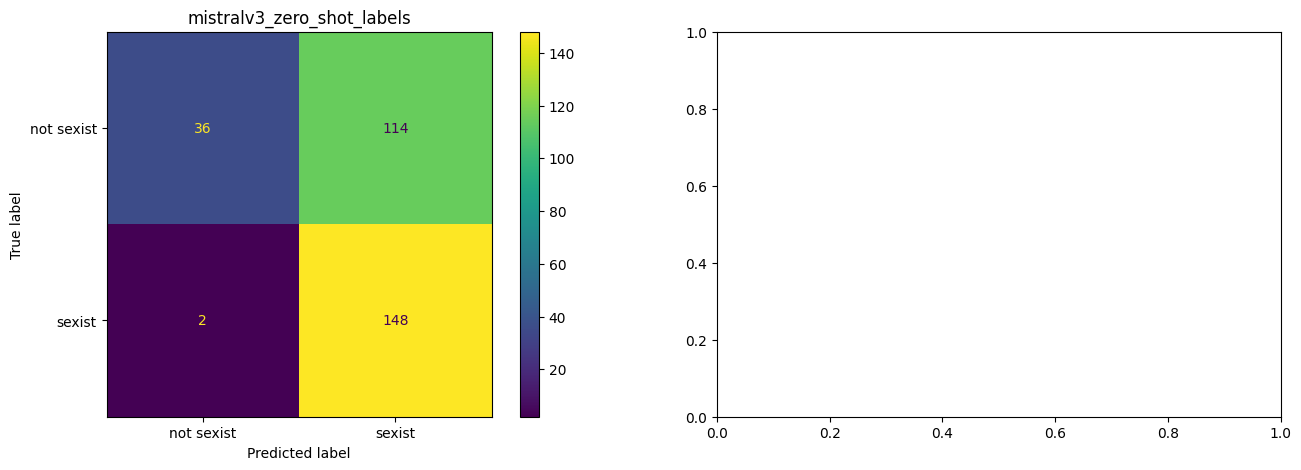

In [ ]:
print_models_confusion_matrixs(['mistralv3_zero_shot_labels', 'llama3_zero_shot_labels'], models_predictions)

zero_shot_df = model_metrics[model_metrics['model'].str.contains('zero shot', case=False)]
zero_shot_df.sort_values('accuracy', ascending=False)

LLaMA 3 outperforms Mistral v3 in zero-shot inference.
The confusion matrix reveals that most errors made by both models involve misclassifying non-sexist tweets as sexist.

Notably, Mistral v3 misclassifies over 75% of non-sexist tweets as sexist, whereas LLaMA 3 misclassifies only 64% of non-sexist tweets as sexist.
Additionally, only a very small portion of comments classified as sexist are misclassified as non-sexist: 1.3% for Mistral v3 and 4.7% for LLaMA 3.

This discrepancy may be due to several factors. The training data might be imbalanced, with more examples of sexist comments, leading to better recognition of sexist patterns. Sexist comments could also have more distinctive linguistic features, making them easier to identify. Additionally, biases in annotation and the need for nuanced understanding of non-sexist comments might contribute to the models' difficulties.

One possible reason for the models being trained on unbalanced data is that the developers aimed to address the generation of unsuitable content. The techniques employed to prevent the generation of such content might have inadvertently led to a significant imbalance between the recognition of the two classes. This imbalance could result in the models being more adept at identifying one class over the other, thus affecting their overall performance.

In [ ]:
print_misslabeled_tweets('Mistralv3', ['mistralv3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing mistralv3_zero_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 


In [ ]:
print_misslabeled_tweets('Llama3', ['llama3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing llama3_zero_shot_labels:
row 16) Giving women all your money is good personality. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 75) Well said. Single mothers would not get this point. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 238) Not all Blacks are complete NIGGERS like this whore The Pure POS Nigger bitch gives others a bad name fucking cunt Should investigate where she worked and deaths 
row 245) To female Bishops stop making fun of religion. 
row 249) I know mine is higher with smart women than dumb women. Or rather, it's lower with dumb women because my lack of knowledge or interest in what (Insert celeb

The comments misclassified by Mistral v3 are clearly mislabeled, whereas those misclassified by LLaMA 3 are clearly false negatives. This suggests that Mistral v3 received training that better enables it to identify sexist comments compared to LLaMA 3. This difference in performance may be attributed to the specific techniques used during training, which might have focused more on recognizing and preventing the generation of unsuitable content. Consequently, this focus could have led to an imbalance in the training data, enhancing Mistral v3's ability to detect sexist comments but also increasing the likelihood of misclassifying non-sexist comments.

### Task 6.3 - Model performance evaluation with few shot inference


In the next session, we will compare the performance of the base models with various few-shot techniques. The base model will serve as a baseline to evaluate the extent of improvements achieved through few-shot prompting. We aim to determine whether a model that performs poorly with zero-shot inference can improve when provided with a few examples in the prompt. Additionally, we will identify the most effective few-shot technique for the task of labeling comments as sexist or non-sexist. This analysis will help us understand the potential of few-shot learning in enhancing model accuracy for this specific classification task.

#### Few shot with ramdomly sampled examplse from the dataset



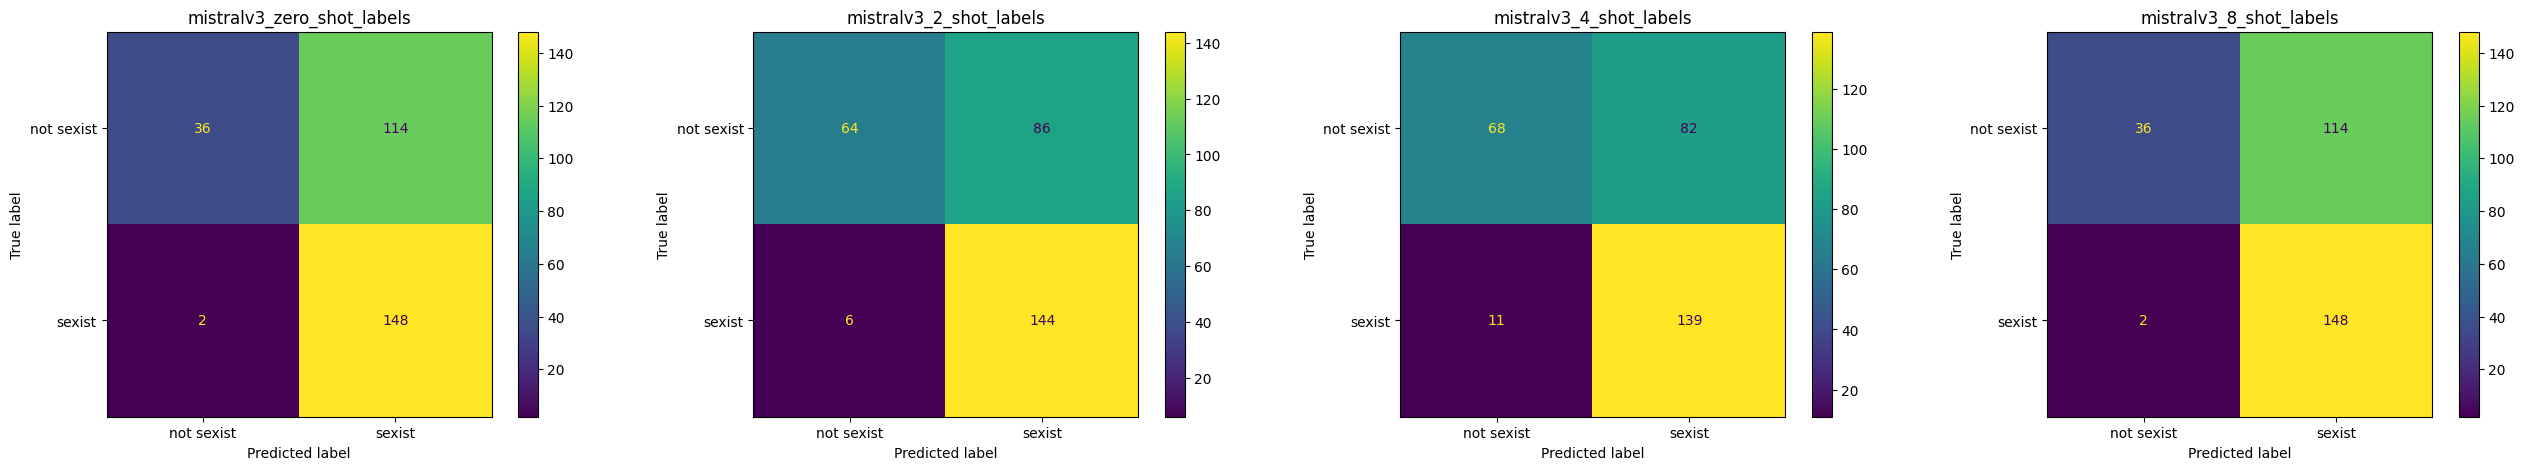

,model,accuracy,fail_ratio
1,Mistral v3 2 shot,0.693333,0.306667
2,Mistral v3 4 shot,0.690000,0.310000
0,Mistral v3 zero shot,0.613333,0.386667
3,Mistral v3 8 shot,0.613333,0.386667


In [ ]:
mistral_models_labels = ['mistralv3_zero_shot_labels', 'mistralv3_2_shot_labels', 'mistralv3_4_shot_labels', 'mistralv3_8_shot_labels']
print_models_confusion_matrixs(mistral_models_labels, models_predictions)
mistral_base_prompting =  model_metrics[model_metrics['model'].str.contains('Mistral', case=False) & ~model_metrics['model'].str.endswith('ma')]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The results indicate that Mistral v3's performance improves with two-shot examples, achieving an accuracy of 0.693333 compared to the zero-shot baseline of 0.613333. However, increasing the number of examples to four or eight does not yield further improvements, with the eight-shot model performing identically to the zero-shot model.



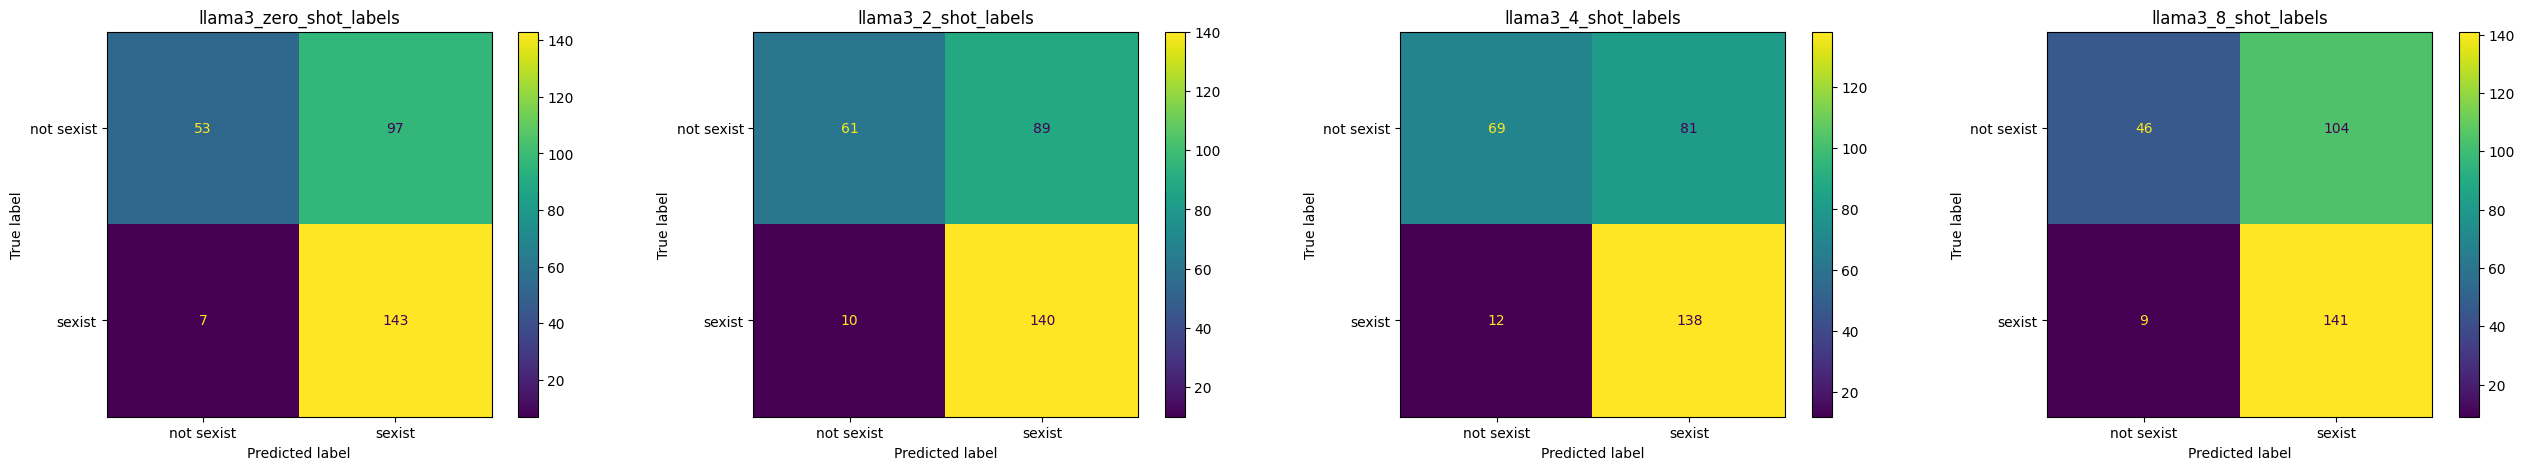

,model,accuracy,fail_ratio
9,llama3 4 shot,0.690000,0.310000
8,Llama3 2 shot,0.670000,0.330000
7,Llama3 zero shot,0.653333,0.346667
10,Llama3 8 shot,0.623333,0.376667


In [ ]:
llama_models_labels = ['llama3_zero_shot_labels', 'llama3_2_shot_labels', 'llama3_4_shot_labels', 'llama3_8_shot_labels']
print_models_confusion_matrixs(llama_models_labels, models_predictions)
llama3_base_prompting =  model_metrics[model_metrics['model'].str.contains('Llama3', case=False) & ~model_metrics['model'].str.endswith('ma')]
llama3_base_prompting.sort_values('accuracy', ascending=False)

The table shows that LLaMA 3's performance improves with two-shot and four-shot examples, achieving the highest accuracy of 0.690000 with four-shot examples. However, the eight-shot model performs worse than the zero-shot model, with a decline in accuracy to 0.623333. This suggests that while a few examples can enhance performance, too many examples can degrade it.


We suspect that the inconsistent performance in both models is due to the poor quality of the examples used in multiple-shot learning. These examples were randomly extracted from the dataset, which may have led to suboptimal training and the observed lack of improvement. It is important to note that, despite being random, the models were prompted with the same textual prompt for each respective prompting technique.

To eliminate the potential problems associated with random selection and better assess the models' performance and to verify the previus claims, we conducted another evaluation of the prompt. This time, the examples injected into the prompt were manually checked by us in order to avoid issues arising from mislabeled or non-meaningful examples.

#### Few shot with manually annotated examples in the prompt

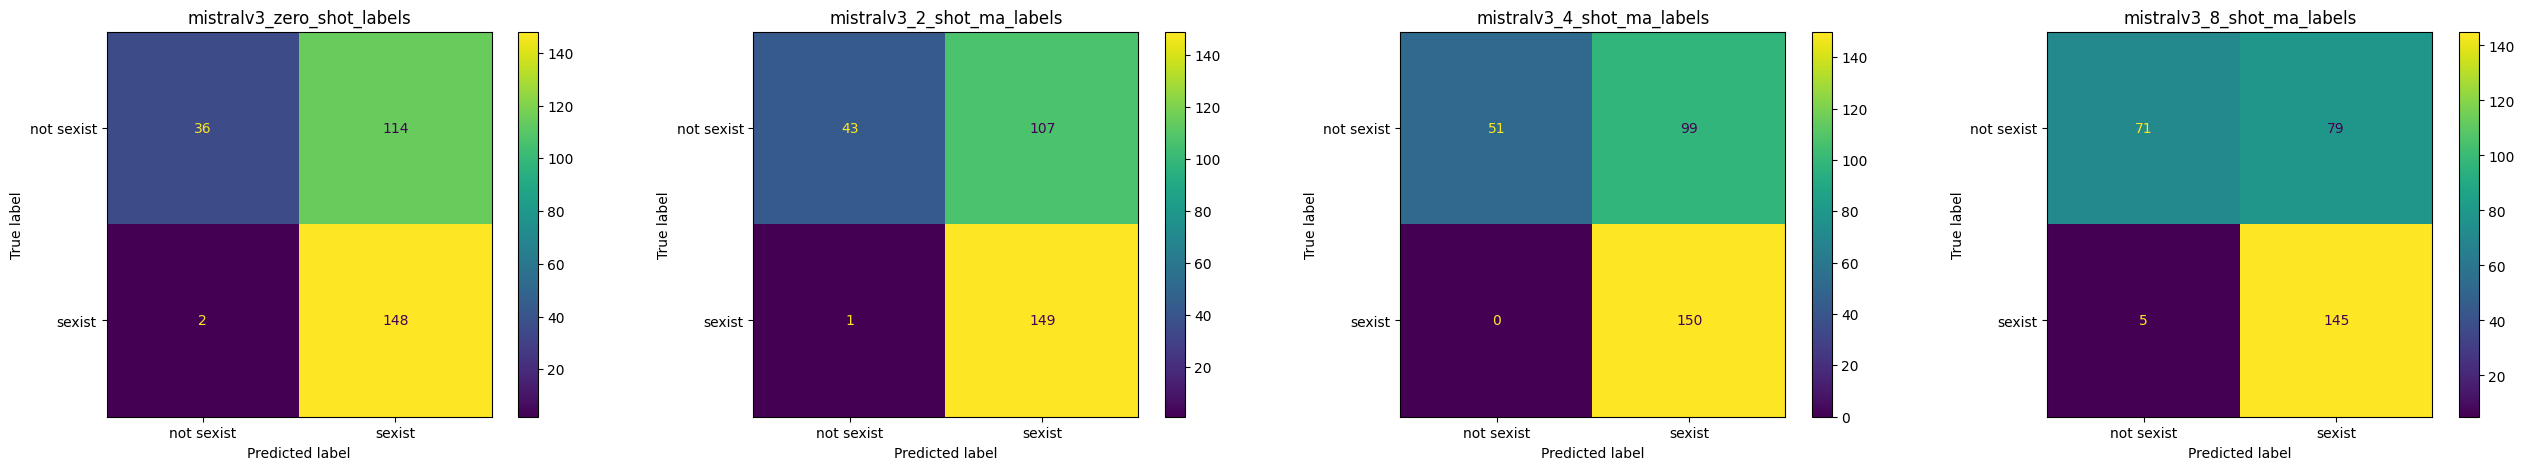

,model,accuracy,fail_ratio
6,Mistral v3 8 shot ma,0.720000,0.280000
5,Mistral v3 4 shot ma,0.670000,0.330000
4,Mistral v3 2 shot ma,0.640000,0.360000
0,Mistral v3 zero shot,0.613333,0.386667


In [ ]:
mistral_models_labels = ['mistralv3_zero_shot_labels', 'mistralv3_2_shot_ma_labels', 'mistralv3_4_shot_ma_labels', 'mistralv3_8_shot_ma_labels']
print_models_confusion_matrixs(mistral_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Mistral', case=False) &
                                                    (model_metrics['model'].str.endswith('ma') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

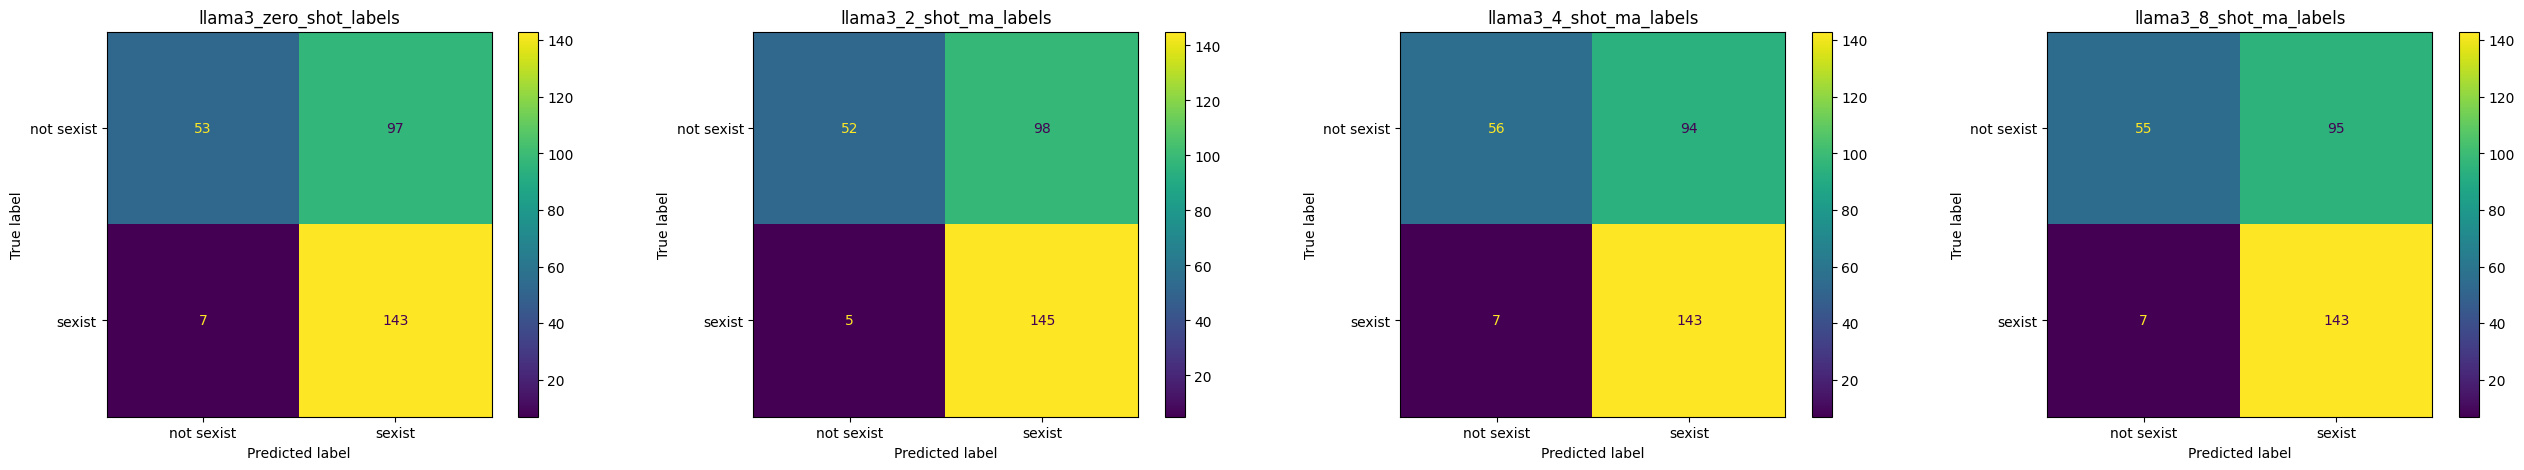

,model,accuracy,fail_ratio
12,Llama3 4 shot ma,0.663333,0.336667
13,Llama3 8 shot ma,0.660000,0.340000
11,Llama3 2 shot ma,0.656667,0.343333
7,Llama3 zero shot,0.653333,0.346667


In [ ]:
llama_models_labels = ['llama3_zero_shot_labels', 'llama3_2_shot_ma_labels', 'llama3_4_shot_ma_labels', 'llama3_8_shot_ma_labels']
print_models_confusion_matrixs(llama_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Llama3', case=False) &
                                                    (model_metrics['model'].str.endswith('ma') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The performance of Mistral v3 and LLaMA 3 with manually labeled examples in the prompt shows significant improvements over their zero-shot baselines. For Mistral v3, the zero-shot model has an accuracy of 0.61 and a fail ratio of 0.38. With two-shot manually labeled examples, the accuracy improves to 0.64, and further increases to 0.67 with four-shot examples. The eight-shot model achieves the highest accuracy of 0.72 and the lowest fail ratio of 0.28.

Similarly, LLaMA 3's zero-shot model has an accuracy of 0.65 and a fail ratio of 0.34. The accuracy slightly improves to 0.65 with two-shot examples and further to 0.66 with four-shot examples. The eight-shot model achieves an accuracy of 0.66, which is slightly lower than the four-shot model but still better than the zero-shot baseline.

These results confirm that manually labeled examples significantly enhance the performance of both models compared to randomly selected examples, highlighting the importance of carefully choosing the examples to be injected into the prompt.

### Task 6.4 Best prompting technique error analisys  

The objective of this section is to visualize the errors made by the two models using their best prompting techniques identified in the previous section. This analysis will help us identify the types of errors most commonly committed by the models, providing insights into areas where further improvements are needed.

We start analysing the comment misslcassified as non sexist (false negative)  

In [ ]:
print_misslabeled_tweets('Mistralv3', ["mistralv3_8_shot_ma_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing mistralv3_8_shot_ma_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 
row 167) I'm getting older and I can't keep doing that grind to spin plates / seek out new pussy. I want to be with a woman long term, but want to learn how to avoid this issue from getting in the way. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 284) Don’t hate women I just understand the price that is paid being with them (not sex) and it’s not worth it...AT ALL. 


In [ ]:
print_misslabeled_tweets('Llama3', ["llama3_4_shot_ma_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing llama3_4_shot_ma_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 140) Karma's a bitch! 
row 167) I'm getting older and I can't keep doing that grind to spin plates / seek out new pussy. I want to be with a woman long term, but want to learn how to avoid this issue from getting in the way. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 245) To female Bishops stop making fun of religion. 
row 249) I know mine is higher with smart women than dumb women. Or rather, it's

Add comment here of the false negative

In [ ]:
print_misslabeled_tweets('Mistralv3', ["mistralv3_8_shot_ma_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Mistralv3

Analyzing mistralv3_8_shot_ma_labels:
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 26) Good - the grid girls can finally get back into F1 
row 32) Before I decided to sack Twitter off entirely, I muted about 100 terms, things like Feminism, sexism, racism, Trump, Brexit. Massive fucking list. Made Twitter so much more fun. 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 38) Yes, let's all be LECTURED by a Jack-ass like this Jimbo Bono's Bud in Red #BoycottedOscars #BoycottHollywood 
row 44) They are just so pissed off cuz no woman wants neither one of them an

In [ ]:
print_misslabeled_tweets('Llama3', ["llama3_4_shot_ma_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Llama3

Analyzing llama3_4_shot_ma_labels:
row 2) Old man mogs everyone in this sub 
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 7) Most women find a highly educated and well traveled man sexy. 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 14) The queen is not representing herself and a direct descendant of Muhammad & high up in the Catholic church of the illuminati ... so are you surprised about this abuse of children? 
row 17) Na he's not flirting with her so she's reading him as gay. 
row 26) Good - the grid girls can finally get back into F1 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 38) Yes, let's a

# Task 7 - Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End